# Accessing DC2 data in PostgreSQL at NERSC part 2

Owner: **Joanne Bogart [@jrbogart](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jrbogart)**  
Last Verified to Run: **2020-08-03**

This notebook introduces some additional features of the PostgreSQL database at NERSC.   

__Learning objectives__:

After going through this notebook, you should be able to:
  1. Discover which object catalogs are available
  2. Query on native quantities in those catalogs
  3. Make use of custom functions, in particular for area searches

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

### Prerequisites
Please see the first notebook in this series for instructions on how to gain access to the database.


In [14]:
import psycopg2

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd

Make the db connection

In [15]:
dbname = 'desc_dc2_drp'
dbuser = 'desc_dc2_drp_user'
dbhost = 'nerscdb03.nersc.gov'
dbconfig = {'dbname' : dbname, 'user' : dbuser, 'host' : dbhost}
dbconn = psycopg2.connect(**dbconfig)

## Finding Data
Tables for the Run1.2i data as well as a view to make dpdd quantities more easily accessible are in the `schema` (acts like a namespace) `run12i`.  To reference, say, a table called `position` for Run1.2i use `run12i.position`. 

### Finding Datasets
To find out which datasets are available and by what schema names, query the table `run_provenance`. It's in a special schema known as `public` which does not normally need to be specified.

In [16]:
cols = ['schema_name', 'run_designation','simulation_program', 'db_ingest', 'remarks']
hdrs = ['schema_name', 'run_desig', 'sim_prog','db_ingest', 'remarks']
# Additional columns in run_provenance store software and input data versions
prov_query = 'SELECT '  + ','.join(cols) + ' from run_provenance'
with dbconn.cursor() as cursor:
    cursor.execute(prov_query)
    fmt = '{0!s:14} {1!s:10} {2!s:9} {3!s:15} {4!s}'
    print(fmt.format(hdrs[0], hdrs[1], hdrs[2], hdrs[3], hdrs[4]))
    for record in cursor:
        print(fmt.format(record[0], record[1], record[2], record[3], record[4]))

schema_name    run_desig  sim_prog  db_ingest       remarks
run12p_v4      1.2        phosim    obj+fs_complete Fixes problems with previous Run1.2p versions
run21i_dr1b_v1_pg2 2.1        imsim     obj_complete    Representative run2.1i 6-month dataset; exclude most non-dpdd
run21i_dr1b_v1 2.1        imsim     obj_complete    Representative run2.1i 6-month dataset
run12i         1.2        imsim     obj_complete    Output from production Imsim run 1.2
run12p_dpdd    1.2        phosim    superseded      Flaws include 1. Problems with calibrations 2. Wrong pixel scale. DROPPED 2020-07-07
star_truth     2.2i                 star_truth_complete Source: /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/truth/startruth
sne_truth      2.2i                 sn_truth_complete Source: /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/truth/sntruth
minion_test    2.2i                 obs_db_complete Source is minion16 sqlite db
run22i_dr6c_object 2.2i_dr6c  ImSim     obj_complete    Source is GCR-genera

Normally only datasets where the `db_ingest` field contains 'complete' are of interest

In [17]:
# Pick one of the supported datasets
schema = 'run12p_v4'

### Querying on Native Quantities
Unlike DPDD quantities (all in a single view), native quantities are split across several tables. The first notebook in the PostgreSQL collection shows how to find out which tables belong to a schema and what columns a table has. Alternatively, if you know the column names you want, you can query for the table name.  The following looks for the table containing `ext_shapeHSM_HsmShapeRegauss_resolution`.


In [18]:
column = 'ext_shapehsm_hsmshaperegauss_flag'
find_table_query = "select table_name from information_schema.columns where table_schema='{}' and column_name='{}'"
find_table_query = find_table_query.format(schema, column)
print(find_table_query)
with dbconn.cursor() as cursor:
    cursor.execute(find_table_query)
    for record in cursor:
        print(record[0])

select table_name from information_schema.columns where table_schema='run12p_v4' and column_name='ext_shapehsm_hsmshaperegauss_flag'
dpdd_ref


There is some necessary fussiness here:
* Note `ext_shapeHSM_HsmShapeRegauss_flag` has been transformed to all lower-case in the query. This is required when querying information_schema, where this string is a __value__ in the database (not a column name). 
* In the query single quotes are used around literals like `run12p_v4`. Double quotes won't work.

Now suppose we wanted to combine a cut on this quantity, in table dpdd_ref, with cuts on DPDD quantities like `clean`.  Then the query has to be made on a join of these two tables, where we specify that the value of dpdd_ref.object_id = dpdd.objectid. This causes the corresponding rows from each table (or view) to be treated as if they were assembled into one long row. Here is a simple query showing how this is done. A more realistic one would have more conditions in the `where` clause and might join more than two tables.  

In [19]:
schema = 'run12i'
join_query = 'select count(object_id) from {schema}.dpdd join {schema}.dpdd_ref '
join_query += 'on {schema}.dpdd_ref.object_id = {schema}.dpdd.objectid'
join_query = join_query.format(**locals())
where = " where (ext_shapeHSM_HSmShapeRegauss_flag = 'f') and clean"
join_query += where
print(join_query)                # confirm the query looks reasonable
with dbconn.cursor() as cursor:
    %time cursor.execute(join_query)
    for record in cursor:
        print(record[0])

select count(object_id) from run12i.dpdd join run12i.dpdd_ref on run12i.dpdd_ref.object_id = run12i.dpdd.objectid where (ext_shapeHSM_HSmShapeRegauss_flag = 'f') and clean
CPU times: user 2.38 ms, sys: 1.38 ms, total: 3.76 ms
Wall time: 21.9 s
1526574


### Adjustments for Larger Datasets

In the above query I switched to a different, significantly smaller dataset (2.8 million objects rather than 13.7 million).  For the much larger 2.1i_dr1b_v1 (over 78 million objects) we have to pay some attention to performance.
The dpdd view is formed from a join of 3 tables. **dpdd_ref** is one of them, so in the above query that table is joined to itself, increasing the resources needed to make the query unnecessarily.  It's more efficient to just get all quantities from a join of tables only, but the dpdd view is more than just the result of a join with some of the columns renamed.  `clean` is formed by doing logical operations on several native-quantity flags. Starting with run 2.1i_dr1b_v1 it can be expressed as ```good and not deblend_skipped``` where both `good` and `deblend_skipped` are columns in **dpdd_ref**. (In earlier runs, `good` existed only in the dpdd view as the result of logical operations on several native-quantity flags).  We also have to exclude non-primary objects, as the dpdd view does.  The flag `detect_isprimary` is in the **position** table. The query for run 2.1i_dr1b_v1 can be written as shown in the next cell. Skip it if you're in a hurry; even with these techniques it still takes about 13 minutes.

In [20]:
schema = 'run21i_dr1b_v1'
join_query = 'select count(position.object_id) from {schema}.position left join {schema}.dpdd_ref '
join_query += 'on {schema}.position.object_id = {schema}.dpdd_ref.object_id'
join_query = join_query.format(**locals())
where = " where detect_isprimary and good and (not deblend_skipped) and (ext_shapeHSM_HSmShapeRegauss_flag = 'f')"
join_query += where
print(join_query)                # confirm the query looks reasonable
with dbconn.cursor() as cursor:
    %time cursor.execute(join_query)
    for record in cursor:
        print(record[0])

select count(position.object_id) from run21i_dr1b_v1.position left join run21i_dr1b_v1.dpdd_ref on run21i_dr1b_v1.position.object_id = run21i_dr1b_v1.dpdd_ref.object_id where detect_isprimary and good and (not deblend_skipped) and (ext_shapeHSM_HSmShapeRegauss_flag = 'f')
CPU times: user 15 ms, sys: 25.8 ms, total: 40.8 ms
Wall time: 17min 16s
52412800


In all such joins, **position** should be the first table in the join and left joins should be used, as in the example. This will in general result in better performance since it forces the join(s) to be done in the order specified. All tables are indexed on `object_id`. Only the **position** table has additional indexes (on `detect_isprimary` and on `coord`, a special column used in area searches).

## User-defined Functions (UDFs)

Many math functions from the c library have been wrapped and incorporated in an extension module installed in the database. They have their normal c library names with the prefix c_. Functions with a floating point argument or return value usually have two versions, such as c_log (double precision natural logarithm) and c_logf (single precision). They can be incorporated in queries as in this example using the command-line interface program psql:
```
desc_dc2_drp=> select c_asin(1.0);

     c_asin
-----------------
 1.5707963267949
```
There are also functions specially crafted for HSC or LSST catalogs with suggestive names like `patch_contains`, `tract_from_object_id` (used in q3 in the first notebook of this series), `sky_to_pixel`,..
```
desc_dc2_drp=> select count(*) from run12i.dpdd where tractsearch(objectId, 5063);
 count
--------
 233982
(1 row)
```
### Restricting by tract or patch

Let's try the last query from the previous section restriced to tract 3446 (picked at random), which has about 570,000 objects. 

In [21]:
schema = 'run21i_dr1b_v1'
join_query = 'select count(position.object_id) from {schema}.position left join {schema}.dpdd_ref '
join_query += 'on {schema}.position.object_id = {schema}.dpdd_ref.object_id'
join_query = join_query.format(**locals())
where = " where detect_isprimary and tractsearch(position.object_id, 3446) and  "
where += "good and (not deblend_skipped) and (ext_shapeHSM_HSmShapeRegauss_flag = 'f')"
join_query += where
print(join_query)                # confirm the query looks reasonable
with dbconn.cursor() as cursor:
    %time cursor.execute(join_query)
    for record in cursor:
        print(record[0])

select count(position.object_id) from run21i_dr1b_v1.position left join run21i_dr1b_v1.dpdd_ref on run21i_dr1b_v1.position.object_id = run21i_dr1b_v1.dpdd_ref.object_id where detect_isprimary and tractsearch(position.object_id, 3446) and  good and (not deblend_skipped) and (ext_shapeHSM_HSmShapeRegauss_flag = 'f')
CPU times: user 2.09 ms, sys: 423 µs, total: 2.51 ms
Wall time: 7.33 s
381378


 Tract 3446 has about 1/136 of the objects in the run21i_dr1b_v1 dataset. The elapsed time for the tract query is less than 1/136 of the time taken by the original query. It pays to restrict queries to a tract when possible, even if it means issuing the same query for several tracts. 

### Area Searches
The  **dpdd** view has one extra column, `coord`, which is not formally a DPDD quantity. `coord` is an alternate way (other than `ra` and `dec`) to express location.  A `coord` value is a triple of doubles representing a position on a sphere in units of arcseconds. This column is indexed, which can make certain calculations faster. In particular, using the functions `conesearch` and `boxsearch` (which take a `coord` as input) rather than starting with `ra` and `dec` makes queries much faster.  There are also functions to translate between `coord` and `(ra, dec)`.



#### Cone search
Find all stars satisfying quality cuts within a fixed radius of a particular coordinate.  The function `coneSearch` returns true if `coord` is within the cone centered at (ra, dec) of the specified radius, measured in arcseconds. 

In [22]:
schema = 'run21i_dr1b_v1'
band = 'i'
mag_col = 'mag_' + band
min_SNR = 25   
max_err = 1/min_SNR
pop = 'Stars'
ra = 54.5
decl = -31.4
radius = 240.0
where = ' where (magerr_{band} < {max_err}) and clean and (extendedness < 1.0) and coneSearch(coord, {ra}, {decl}, {radius})'
qcone = ('SELECT ra, dec, mag_{band} from {schema}.dpdd ' + where).format(**locals())
print(qcone)
with dbconn.cursor() as cursor:
    %time cursor.execute(qcone)
    records = cursor.fetchall()
    nObj = len(records)
    print('{} objects found '.format(nObj))

SELECT ra, dec, mag_i from run21i_dr1b_v1.dpdd  where (magerr_i < 0.04) and clean and (extendedness < 1.0) and coneSearch(coord, 54.5, -31.4, 240.0)
CPU times: user 429 µs, sys: 1.98 ms, total: 2.41 ms
Wall time: 4.01 s
67 objects found 


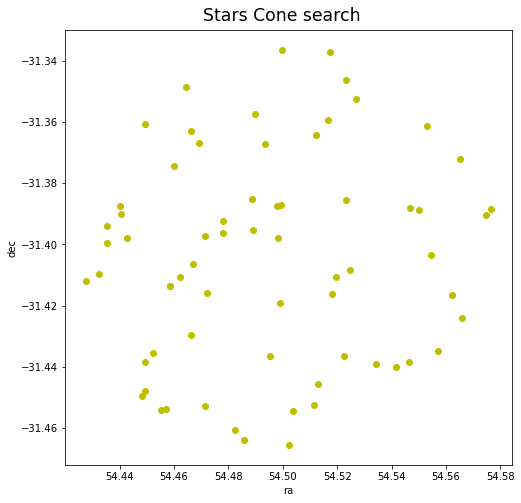

In [23]:
cmags = pd.DataFrame(records, columns=['ra', 'dec', mag_col])

plt.figure(figsize=(8, 8))
plt.xlabel('ra')
plt.ylabel('dec')
plt.suptitle(pop + ' Cone search', size='xx-large', y=0.92)
p = plt.scatter(cmags['ra'], cmags['dec'], color='y')

Notice how fast the query is.   Compare time, # objects found and scatter plot after increasing radius, e.g. by a factor of 10 to 2400.0. 

#### Box search
Find all stars, subject to quality cuts, with the specified ra and dec bounds

In [24]:
ra1 = 54.4
ra2 = 54.8
decl1 = -31.6
decl2 = -31.3

where = ' where (magerr_{band} < {max_err}) and clean and (extendedness < 1.0) and boxSearch(coord, {ra1}, {ra2},{decl1}, {decl2})'
qbox = ('SELECT ra, dec, mag_{band} from {schema}.dpdd ' + where).format(**locals())
print(qbox)
with dbconn.cursor() as cursor:
    %time cursor.execute(qbox)
    records = cursor.fetchall()
    nObj = len(records)
    print('{} objects found '.format(nObj))

SELECT ra, dec, mag_i from run21i_dr1b_v1.dpdd  where (magerr_i < 0.04) and clean and (extendedness < 1.0) and boxSearch(coord, 54.4, 54.8,-31.6, -31.3)
CPU times: user 2.23 ms, sys: 0 ns, total: 2.23 ms
Wall time: 6.44 s
573 objects found 


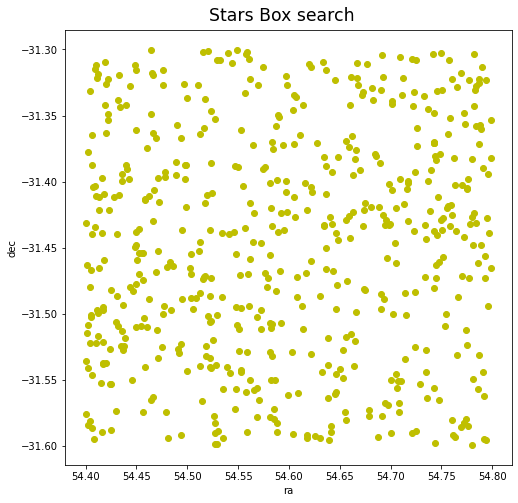

In [25]:
bmags = pd.DataFrame(records, columns=['ra', 'dec', mag_col])

plt.figure(figsize=(8, 8))
plt.xlabel('ra')
plt.ylabel('dec')
plt.suptitle(pop + ' Box search', size='xx-large', y=0.92)
p = plt.scatter(bmags['ra'], bmags['dec'], color='y')
